# Libraries

In [52]:
from pathlib import Path
import os
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

import scipy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay

In [2]:
subfolder_path = Path.cwd()
notebooks_path = subfolder_path.parent
repo_path = notebooks_path.parent
os.chdir(str(subfolder_path))
#print current working directory
print(f'Current folder is: {os.getcwd()}\n')
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent.parent)) if sys.path[0] != str(thispath.parent.parent) else None

#Import paths and patients classes
from notebooks.info import path_label, patient


Current folder is: /home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte/Machine_Learning/notebooks/training_models



# Functions

## Utils

In [3]:
#print 3 channel image given its numpy array
def show_image_3channels(image):
    """Print 3 channel image given its numpy array
    """
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()
    
#functio to save file as pickle
def save_as_pickle(file, filename):
    """Save file as pickle
    """
    with open(filename, 'wb') as f:
        pickle.dump(file, f, pickle.HIGHEST_PROTOCOL)
def load_pickle(filename):
    """Load pickle file
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)

## Classifiers

In [4]:
def classifier_grid(method, grid_type='normal', scaler=StandardScaler(), reductor_components = [0.99], verbose=4):
    """get pipe and grid for classifier

    Args:
        method (str): classifier name
        scaler (scikit object, optional): type of scaler. Defaults to StandardScaler().
        verbose (int, optional): verbose level. Defaults to 4.

    Returns:
        _type_: _description_
    """
   #KNN
    if(method=='KNN'):
        param_grid = {'classifier__n_neighbors': list(range(1,32))}
        pipe = Pipeline([('scaler', scaler),('classifier',KNeighborsClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    if(method=='KNN_PCA'):
        param_grid = {'reductor__n_components': reductor_components, 'classifier__n_neighbors': list(range(1,32))}
        pipe = Pipeline([('scaler', scaler),('reductor',PCA()), ('classifier',KNeighborsClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    #RF
    elif(method=='RF'):
        param_grid = {'classifier__n_estimators': [100, 200, 400]}
        pipe = Pipeline([('scaler', scaler),('classifier',RandomForestClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    
    elif(method=='RF_PCA'):
        param_grid = {'reductor__n_components': reductor_components,'classifier__n_estimators': [100, 200, 400],}
        pipe = Pipeline([('scaler', scaler),('reductor',PCA()), ('classifier',RandomForestClassifier())])
        grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
        return grid, pipe
    #SVM
    elif(method=='SVM'):
        if(grid_type=='normal'):
            param_grid = {'classifier__C': [1, 10, 100, 1000],
                    'classifier__gamma': [0.1, 0.01, 0.001, 0.0001],
                    'classifier__kernel': ['rbf']}
            pipe = Pipeline([('scaler', scaler),('classifier',SVC())])
            grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
            return grid, pipe
        elif(grid_type=='random'):
            parameters = {'classifier__C': scipy.stats.expon(scale=10), 'classifier__gamma': scipy.stats.expon(scale=.1), #Parameters for grid search
            'classifier__kernel': ['rbf'], 'classifier__class_weight':['balanced']}
            pipe = Pipeline([('scaler', scaler),('classifier',SVC())]) #Definition of pipeline
            grid = RandomizedSearchCV(pipe, parameters,n_iter=20, scoring='accuracy', verbose=verbose, return_train_score=False) #Random search
            return grid, pipe
    elif(method=='SVM_PCA'):
        if(grid_type=='normal'):
            param_grid = {'reductor__n_components': reductor_components, 'classifier__C': [1, 10, 100],
                    'classifier__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                    'classifier__kernel': ['rbf'],'classifier__class_weight':['balanced']}
            pipe = Pipeline([('scaler', scaler),('reductor',PCA()), ('classifier',SVC())])
            grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
            return grid, pipe
        elif(grid_type=='random'):
            parameters = {'reductor__n_components': reductor_components, 'classifier__C': scipy.stats.expon(scale=10), 'classifier__gamma': scipy.stats.expon(scale=.1), #Parameters for grid search
            'classifier__kernel': ['rbf'], 'classifier__class_weight':['balanced']}
            pipe = Pipeline([('scaler', scaler),('reductor',PCA()), ('classifier',SVC())]) #Definition of pipeline
            grid = RandomizedSearchCV(pipe, parameters,n_iter=100, scoring='accuracy', verbose=verbose, return_train_score=False) #Random search
            return grid, pipe
    #ADA
    elif(method=='AdaBoost'):
        param_grid = {'classifier__n_estimators': [50,100, 200, 400], 'classifier__learning_rate': [ 0.1, 1,5, 10]}
        pipe = Pipeline([('scaler', scaler),('classifier',AdaBoostClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    elif(method=='AdaBoost_PCA'):
        param_grid = {'reductor__n_components': reductor_components, 'classifier__n_estimators': [50,100, 200, 400], 'classifier__learning_rate': [ 0.1, 1,5, 10]}
        pipe = Pipeline([('scaler', scaler),('reductor',PCA()),('classifier',AdaBoostClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    #GradientBoosting
    elif(method=='GradBoost'):
        param_grid = {'classifier__learning_rate': [0.01, 0.1, 1, 10], 'classifier__max_iter': [100, 200, 400]}
        pipe = Pipeline([('scaler', scaler), ('classifier',GradientBoostingClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe
    #XGBoost
    elif(method == 'XGBoost'):
        param_grid = {'classifier__max_depth': range (2, 10, 1), 'classifier__n_estimators': range(600, 1000, 200), 'classifier__learning_rate': [0.1, 0.01, 0.05]}
        pipe = Pipeline([('scaler', scaler), ('classifier',XGBClassifier())])
        grid = GridSearchCV(pipe, param_grid, verbose = verbose)
        return grid, pipe


## Data loading

In [5]:
def get_XandY(classif, set_name, fname):
    """Get X and y values for any data set

    Args:
        classif (str): binary or multiclass
        set_name (str): _description_
        ftype (str): _description_
        fname (str): _description_

    Returns:
        _type_: _description_
    """
    info = path_label(classif=classif, set_name=set_name)
    #Load features and labels
    path1 = str(repo_path) + f'/data/features/texture/{classif}_{set_name}_{fname}_fv.p'
    path2 = str(repo_path) + f'/data/features/color/{classif}_{set_name}_{fname}_fv.p'
    X_data = load_pickle(path1) if Path(path1).exists() else load_pickle(path2)
    y_data = info.labels

    return X_data, y_data

def get_X(classif, set_name, fname):
    """Get X values for any data set

    Args:
        classif (str): binary or multiclass
        set_name (str): _description_
        ftype (str): _description_
        fname (str): _description_

    Returns:
        _type_: _description_
    """
    
    #Load features and labels
    path1 = str(repo_path) + f'/data/features/texture/{classif}_{set_name}_{fname}_fv.p'
    path2 = str(repo_path) + f'/data/features/color/{classif}_{set_name}_{fname}_fv.p'
    X_data = load_pickle(path1) if Path(path1).exists() else load_pickle(path2)
    
    return X_data

def get_trainVal(classif, flist):
    """returns train and validation data

    Args:
        classif (st): binary or multiclass
        flist (list): list of features

    Returns:
        4 arrays: 4 arrays of train and validation data
    """
    X_train_tot = []
    X_val_tot = []
    for fname in flist:
        X_train, y_train = get_XandY(classif, 'train', fname)
        X_val, y_val = get_XandY(classif, 'val', fname)
        
        X_train_tot.append(X_train)
        X_val_tot.append(X_val)
    
    X_train_tot = np.concatenate(X_train_tot, axis=1)
    X_val_tot = np.concatenate(X_val_tot, axis=1)
    
    return X_train_tot, y_train, X_val_tot, y_val

def get_test(classif, flist):
    """returns train and validation data

    Args:
        classif (st): binary or multiclass
        flist (list): list of features

    Returns:
        4 arrays: 4 arrays of train and validation data
    """
    X_test_tot = []
    for fname in flist:
        X_test = get_X(classif, 'test', fname)
        
        X_test_tot.append(X_test)
    
    X_test_tot = np.concatenate(X_test_tot, axis=1)
    
    return X_test_tot

In [6]:
def ml_pipeline(classif, fname, classifier, grid_search, verbose=4):
        
    #Get X and y values
    X_train, y_train, X_val, y_val = get_trainVal(classif, fname)
    #Define classifier
    grid, _ = classifier_grid(classifier, grid_search, scaler=StandardScaler(), verbose=verbose)
    #train classifier
    model = grid.fit(X_train,y_train)
    #Save model
    save_as_pickle(model, str(repo_path) + f'/data/models/{classif}_{classifier}_{grid_search}_{fname}.p')
    #Predict for validation
    y_pred = model.predict(X_val)
    #Get metrics
    acc = np.mean(y_pred == y_val)
    print(f'The accuracy of the model is: {acc}')
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap='Blues', normalize='true')
    plt.show()
    return y_pred, X_val, y_val, model

# IMP

The accuracy of the model is: 0.8519494204425712


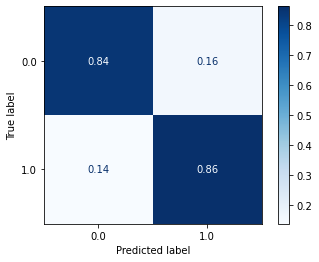

In [15]:
classif = 'binary'
#fname = ['RGBColorStats_WH', 'Alltexture_WH']
fname = ['mainstats_NH', 'Alltexture_WH', 'lbp_NH']
classifier = 'SVM'
grid_search = 'normal'
verbose = 4

#Get X and y values
X_train, y_train, X_val, y_val = get_trainVal(classif, fname)
#Define classifier
grid, _ = classifier_grid(classifier, grid_search, scaler=StandardScaler(), verbose=verbose)
# #train classifier
# model = grid.fit(X_train,y_train)
# #Save model
# save_as_pickle(model, str(repo_path) + f'/data/models/{classif}_{classifier}_{grid_search}_{fname}.p')
# #Predict for validation
y_pred = model.predict(X_val)
#Get metrics
acc = np.mean(y_pred == y_val)
print(f'The accuracy of the model is: {acc}')
ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap='Blues', normalize='true')
plt.show()

# Crete prediction for test set

In [39]:
def prediction(classif, X_test, model, save=False, name = 'binary_results'):
    """makes prediction for test set and saves it in a csv file

    Args:
        X_test (np array): testing features
        model (_type_): _description_
        save (bool, optional): _description_. Defaults to False.
        name (str, optional): _description_. Defaults to 'binary_results'.

    Returns:
        _type_: _description_
    """
#prediction
    y_pred_test = model.predict(X_test) #predict
    y_pred_test = LabelEncoder().fit_transform(y_pred_test) #transform to 0 and 1 integers
    #invert elements 0 and 1 in vector
    y_pred_test[y_pred_test == 0] = 2
    y_pred_test[y_pred_test == 1] = 0
    y_pred_test[y_pred_test == 2] = 1
    #count elements in array

    unique, counts = np.unique(y_pred_test, return_counts=True)
    print(f'Elements: {unique} and counts: {counts}')

    meta = pd.read_csv(str(repo_path) + '/data/meta_info.csv', sep='\t') #For labels
    meta = meta.loc[meta['classif'] == classif] #Filter by classif
    meta = meta.loc[meta['set'] == 'test'] #Filter by set

    y_pred_test_pd = pd.DataFrame(y_pred_test, columns=['label'])
    #save as excel
    y_pred_test_pd.to_excel(str(repo_path) + f'/data/{name}.xlsx', index=False, header = False) if save==True else print('No save')
    
    return y_pred_test_pd

In [45]:
fname = ['mainstats_NH', 'Alltexture_WH', 'lbp_NH']
classifier = 'SVM'
#Get test features
X_test = get_test(classif, fname)
#Charge model
model = load_pickle(str(repo_path) + f'/data/models/{classif}_{classifier}_{grid_search}_{fname}.p')
#Predict
y_pred_test_pd = prediction(classif, X_test, model, save=True, name = f'best_binary_results')

Elements: [0 1] and counts: [3270 3070]


              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85      1865
         1.0       0.85      0.86      0.86      1931

    accuracy                           0.85      3796
   macro avg       0.85      0.85      0.85      3796
weighted avg       0.85      0.85      0.85      3796



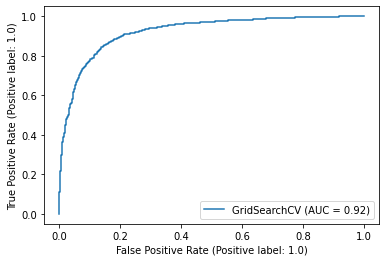

In [55]:
print(classification_report(y_val, y_pred))
RocCurveDisplay.from_estimator(model, X_val, y_val)

# Kappa check

In [47]:
#read csv files with predictions
binary_results = pd.read_excel(str(repo_path) + '/data/best_binary_results.xlsx')
#read xlsx file with labels
alex_results = pd.read_excel(str(repo_path) + '/data/results/Cortina_Yalcin_binary_results2.xlsx', header=None)
old_results = pd.read_csv(str(repo_path) + '/data/results/binary_results_notbest.csv')

binary_results.values
cohen_kappa_score(binary_results.labels.values, old_results.values)

AttributeError: 'DataFrame' object has no attribute 'labels'

In [44]:
old_results

,0,1
0,id,label
1,1,0.0
2,2,0.0
3,3,0.0
4,4,1.0
...,...,...
6336,6336,1.0
6337,6337,1.0
6338,6338,1.0
6339,6339,0.0
